# REINFORCE in TensorFlow

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.


$\nabla J = \underset{s \sim d(s), a \sim \pi} E \nabla log \pi ( a | s) * G(s, a)$  

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


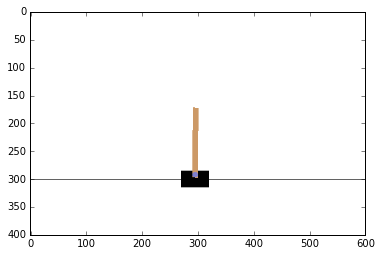

In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [2]:
print(n_actions)
print(state_dim)

2
(4,)


# Building the policy network

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__. 

We'll use softmax or log-softmax where appropriate.

In [3]:
print((None,)+state_dim)

(None, 4)


In [4]:
import tensorflow as tf

#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', (None,) + state_dim, name="states")
actions = tf.placeholder('int32', (None,), name="action_ids") # PWE None added
cumulative_rewards = tf.placeholder('float32', (None,), name="cumulative_returns") # PWE None added

/home/philippew/anaconda3/envs/pythonx/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
print(states)
print(actions)
print(cumulative_rewards)

Tensor("states:0", shape=(?, 4), dtype=float32)
Tensor("action_ids:0", shape=(?,), dtype=int32)
Tensor("cumulative_returns:0", shape=(?,), dtype=float32)


In [6]:
n_neurons = 40

n_states = state_dim[0]
print(n_actions)
print(n_states)
print(n_neurons)

2
4
40


In [7]:
W1 = tf.get_variable("W1", shape=[n_states, n_neurons], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b1 = tf.get_variable("b1", shape=[n_neurons], dtype=tf.float32, initializer=tf.zeros_initializer())

W2 = tf.get_variable("W2", shape=[n_neurons, n_neurons], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b2 = tf.get_variable("b2", shape=[n_neurons], dtype=tf.float32, initializer=tf.zeros_initializer())

W = tf.get_variable("W", shape=[n_neurons, n_actions], dtype=tf.float32, initializer=tf.glorot_uniform_initializer())
b = tf.get_variable("b", shape=[n_actions], dtype=tf.float32, initializer=tf.zeros_initializer())

print(W1, b1)
print(W2, b2)
print(W, b)

<tf.Variable 'W1:0' shape=(4, 40) dtype=float32_ref> <tf.Variable 'b1:0' shape=(40,) dtype=float32_ref>
<tf.Variable 'W2:0' shape=(40, 40) dtype=float32_ref> <tf.Variable 'b2:0' shape=(40,) dtype=float32_ref>
<tf.Variable 'W:0' shape=(40, 2) dtype=float32_ref> <tf.Variable 'b:0' shape=(2,) dtype=float32_ref>


In [8]:
#<define network graph using raw tf or any deep learning library>
# Neural Network setup
z1 = tf.nn.relu(tf.matmul(states, W1) + b1)
z2 = tf.nn.relu(tf.matmul(z1, W2) + b2)
#logits = <linear outputs (symbolic) of your network>
logits = tf.matmul(z2, W) + b

policy = tf.nn.softmax(logits)
print(policy)

log_policy = tf.nn.log_softmax(logits)
print(log_policy)

Tensor("Softmax:0", shape=(?, 2), dtype=float32)
Tensor("LogSoftmax:0", shape=(?, 2), dtype=float32)


In [9]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [10]:
print(cumulative_rewards)

Tensor("cumulative_returns:0", shape=(?,), dtype=float32)


In [11]:
actions_onehot = tf.one_hot(actions, n_actions, dtype='float32')
print(actions_onehot)

loss = - tf.reduce_mean(tf.reduce_sum(actions_onehot * log_policy, axis=1) * cumulative_rewards)
print(loss)

Tensor("one_hot:0", shape=(?, 2), dtype=float32)
Tensor("Neg:0", shape=(), dtype=float32)


In [12]:
print(actions_onehot)
print(log_policy)
print(cumulative_rewards)
print(loss)

Tensor("one_hot:0", shape=(?, 2), dtype=float32)
Tensor("LogSoftmax:0", shape=(?, 2), dtype=float32)
Tensor("cumulative_returns:0", shape=(?,), dtype=float32)
Tensor("Neg:0", shape=(), dtype=float32)


0.6931466795583598 0.49949949949959954


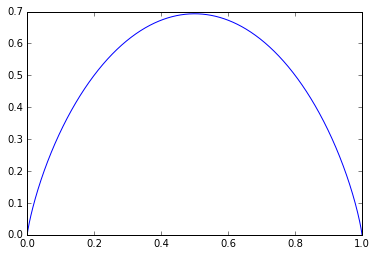

In [13]:
# ENTROPY PLOT

epsilon=1e-10
x = np.linspace(0+epsilon, 1-epsilon, num=1000)
#print(x)
y = -(x * np.log(x) + (1-x) * np.log(1-x))
#print(y)
plt.plot(x, y)
print(np.max(y), x[np.argmax(y)])

In [ ]:
entropy = tf.reduce_mean(- policy * log_policy)
# OR tf.reduce_sum ???
print(entropy)

In [ ]:
loss = loss -0.1 * entropy
print(loss)

In [14]:
update = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
#get probabilities for parti
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions],axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [ ]:
# policy objective as in the last formula. please use mean, not sum.
# note: you need to use log_policy_for_actions to get log probabilities for actions taken

J = <YOUR CODE

In [ ]:
#regularize with entropy
entropy = <compute entropy. Don't forget the sign!>

In [ ]:
#all network weights
all_weights = <a list of all trainable weights in your network>

#weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J -0.1 * entropy

update = tf.train.AdamOptimizer().minimize(loss,var_list=all_weights)

### Computing cumulative rewards

In [15]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    #<your code here>
    n_rewards = len(rewards)
    cumulative_rewards = []
    
    for i in range(n_rewards):
        cumulative_reward = rewards[i]
        weight = gamma
        for j in range(i+1, n_rewards):
            cumulative_reward += weight * rewards[j]
            weight *= gamma
        #print(cumulative_reward)
        cumulative_rewards.append(cumulative_reward)
            
    #return <array of cumulative rewards>
    return np.array(cumulative_rewards)

In [16]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0], gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [17]:
def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    #print(cumulative_rewards)
    #print(_cumulative_rewards.shape)
    update.run({states:_states, actions:_actions, cumulative_rewards:_cumulative_rewards})

### Playing the game

In [18]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states, actions, rewards = [], [], []
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        #a = <pick random action using action_probas>
        a = np.random.choice(n_actions, 1, p=action_probas)[0]
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states, actions, rewards)
            
    return sum(rewards)
        

In [19]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:28.460
mean reward:27.030
mean reward:45.030
mean reward:83.880
mean reward:37.970
mean reward:60.700
mean reward:173.280
mean reward:224.360
mean reward:615.760
You Win!


### Results & video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'philippe.weingertner@laposte.net', 'Ue9yGJhHwpA54YEt')

In [20]:
import sys
import numpy as np
sys.path.append("..")
import grading


def submit_cartpole(generate_session, email, token):
    sessions = [generate_session() for _ in range(100)]
    session_rewards = np.array(sessions)
    print(int(np.mean(session_rewards)))
    grader = grading.Grader("oyT3Bt7yEeeQvhJmhysb5g")
    grader.set_answer("7QKmA", int(np.mean(session_rewards)))
    grader.submit(email, token)

In [21]:
submit_cartpole(generate_session, 'philippe.weingertner@laposte.net', 'Ue9yGJhHwpA54YEt')

376
You used an invalid email or your token may have expired. Please make sure you have entered all fields correctly. Try generating a new token if the issue still persists.


In [24]:
submit_cartpole(generate_session, 'philippe.weingertner@laposte.net', 'CiKRj0CWBTFuoZMn')

718
Submitted to Coursera platform. See results on assignment page!


In [ ]:
# That's all, thank you for your attention!
# Not having enough? There's an actor-critic waiting for you in the honor section.
# But make sure you've seen the videos first.